In [1]:
import matplotlib.pyplot as plt
import pickle
import datetime as dt
import numpy as np
import pandas as pd

/Users/Sam/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from sklearn.linear_model import LinearRegression as LM
from sklearn.linear_model import RidgeCV as Ridge
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.neighbors import RadiusNeighborsRegressor as radNN
from sklearn.ensemble import ExtraTreesRegressor as ET
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import AdaBoostRegressor as Ada
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor as ANN

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
from sklearn.metrics import mean_squared_error, r2_score

In [18]:
reg = {'LM':LM(),
#      'Ridge':Ridge(),
#      'KNN':KNN(),
#      'radNN':radNN(radius=200),
      'DT':DT(random_state=1337),
      'RF':RF(random_state=1337),
      'ET':ET(random_state=1337), #n_estimators=100, random_state=0
#      'Ada':Ada(),
#      'SVM':SVR(),
      'ANN':ANN(max_iter=400,random_state=1337) #hidden_layer_sizes=(50,),max_iter=400,random_state=42
      } #shuffle=False,

In [6]:
tsla_price = pickle.load(open("../data/data_h_corrected.pickle","rb"))['Open']
tsla_trend = pickle.load(open("../data/GT_tsla_h.pickle","rb"))
musk_trend = pickle.load(open("../data/GT_musk_h.pickle","rb"))
musk_twitter = pickle.load(open("../data/twitter_musk_h.pickle","rb"))
musk_tesla_twitter = pickle.load(open("../data/twitter_musk_tesla_h.pickle","rb"))

In [7]:
start_ts = tsla_price.index[0]
end_ts = tsla_price.index[-1]
tsla_trend = tsla_trend[start_ts:end_ts]
musk_trend = musk_trend[start_ts:end_ts]
#musk_twitter = musk_twitter[start_ts:end_ts]
musk_tesla_twitter = musk_tesla_twitter[start_ts:end_ts]
data = pd.concat([tsla_price,tsla_trend,musk_trend,musk_tesla_twitter],axis=1)
#need to replace NAN in the musk_tesla_twitter columns with zero, or the later step of removing NAN rows will delete stuff I don't want
#to delete. This is because I didn't preprocess the musk_tesla_twitter data the same way as the musk_twitter
data[["like_count","retweet_count","reply_count","quote_count"]] = data[["like_count","retweet_count","reply_count","quote_count"]].fillna(0)
#print(data.head(10))

                          Open  tsla  musk  like_count  retweet_count  \
2019-02-11 10:00:00  62.349998  1.62  3.36     71095.0         4636.0   
2019-02-11 11:00:00  63.153004  2.61   3.5         0.0            0.0   
2019-02-11 12:00:00  62.935997  4.23  3.64         0.0            0.0   
2019-02-11 13:00:00  63.230000  5.49  3.71         0.0            0.0   
2019-02-11 14:00:00  62.996002  8.46  3.92         0.0            0.0   
2019-02-11 15:00:00  62.826836   9.0  4.13         0.0            0.0   
2019-02-11 16:00:00  62.770000  7.92  4.34         0.0            0.0   
2019-02-11 17:00:00        NaN  7.65  4.62         0.0            0.0   
2019-02-11 18:00:00        NaN  7.74   4.9         0.0            0.0   
2019-02-11 19:00:00        NaN  7.74  5.04         0.0            0.0   

                     reply_count  quote_count  
2019-02-11 10:00:00       2820.0        485.0  
2019-02-11 11:00:00          0.0          0.0  
2019-02-11 12:00:00          0.0          0.0  
2019

In [8]:
cut_date = dt.datetime(year=2021,month=1,day=4,hour=10) # For now just testing various cut point around 2 month
print('cut date = ',cut_date)

cut date =  2021-01-04 10:00:00


In [9]:
def split_data(data,cut_idx):
    train = data[:cut_idx]
    test = data[cut_idx:]
    return train, test

In [10]:
def convert_to_logret(stock_price):
    initial = stock_price.iloc[0]
    returns = 100*(np.log(stock_price)).diff()
    return returns, initial

def convert_from_logret(returns,initial,axis=0):
    stock_price = np.exp((returns/100).cumsum(axis)) * initial
    return stock_price

In [11]:
time = pd.Series(data=range(len(tsla_trend)),index=tsla_trend.index)
data['time'] = time
returns, initial = convert_to_logret(tsla_price)
data['returns'] = returns
#print(data.head(20))
data.dropna(inplace=True)
#print(data.head(20))

In [12]:
def shift(df,column,list_shifts):
    for i in list_shifts:
        name = column + str(-i)
        df[name]=df[column].shift(i)
    return df

In [13]:
data = shift(data,'returns',range(-35*4+1,35*4+1))
data = shift(data,'tsla',range(1,35*4+1))
data = shift(data,'musk',range(1,35*4+1))
data = shift(data,'like_count',range(1,35*4+1))
data = shift(data,'retweet_count',range(1,35*4+1))
data = data.dropna()

In [14]:
forward_timesteps = 35 #one week
backward_timesteps = -35*4 #four weeks

stock_variables = ["returns"]+['returns'+str(i) for i in range(backward_timesteps,0)]
g_trend_variables = ["tsla","musk"]+['tsla'+str(i) for i in range(backward_timesteps,0)]#+['musk'+str(i) for i in range(backward_timesteps,0)]
twitter_variables = [] + ["retweet_count"]+['retweet_count'+str(i) for i in range(backward_timesteps,0)]#+ ["like_count"]+['like_count'+str(i) for i in range(backward_timesteps,0)]

feature_list = stock_variables + g_trend_variables + twitter_variables + ["time"]
response_list = ["returns"]+['returns'+str(i) for i in range(1,forward_timesteps)]

features = data[feature_list]
responses = data[response_list]

cut_idx = pd.Timestamp(cut_date)

x_train, x_test = split_data(features,cut_idx)
y_train, y_test = split_data(responses,cut_idx)

#correction for overlapping features and responses:
x_train = x_train[:-forward_timesteps]
y_train = y_train[:-forward_timesteps]
    
#Scaler
scaler = MinMaxScaler()
x_train_minmax = scaler.fit_transform(x_train,y_train)
    
metrics = pd.DataFrame(index=reg.keys(),columns=["MSE","R2","MSE_original_scale","R2_original_scale"])

In [19]:
for model in reg:
    reg[model].fit(x_train_minmax,y_train)

/Users/Sam/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


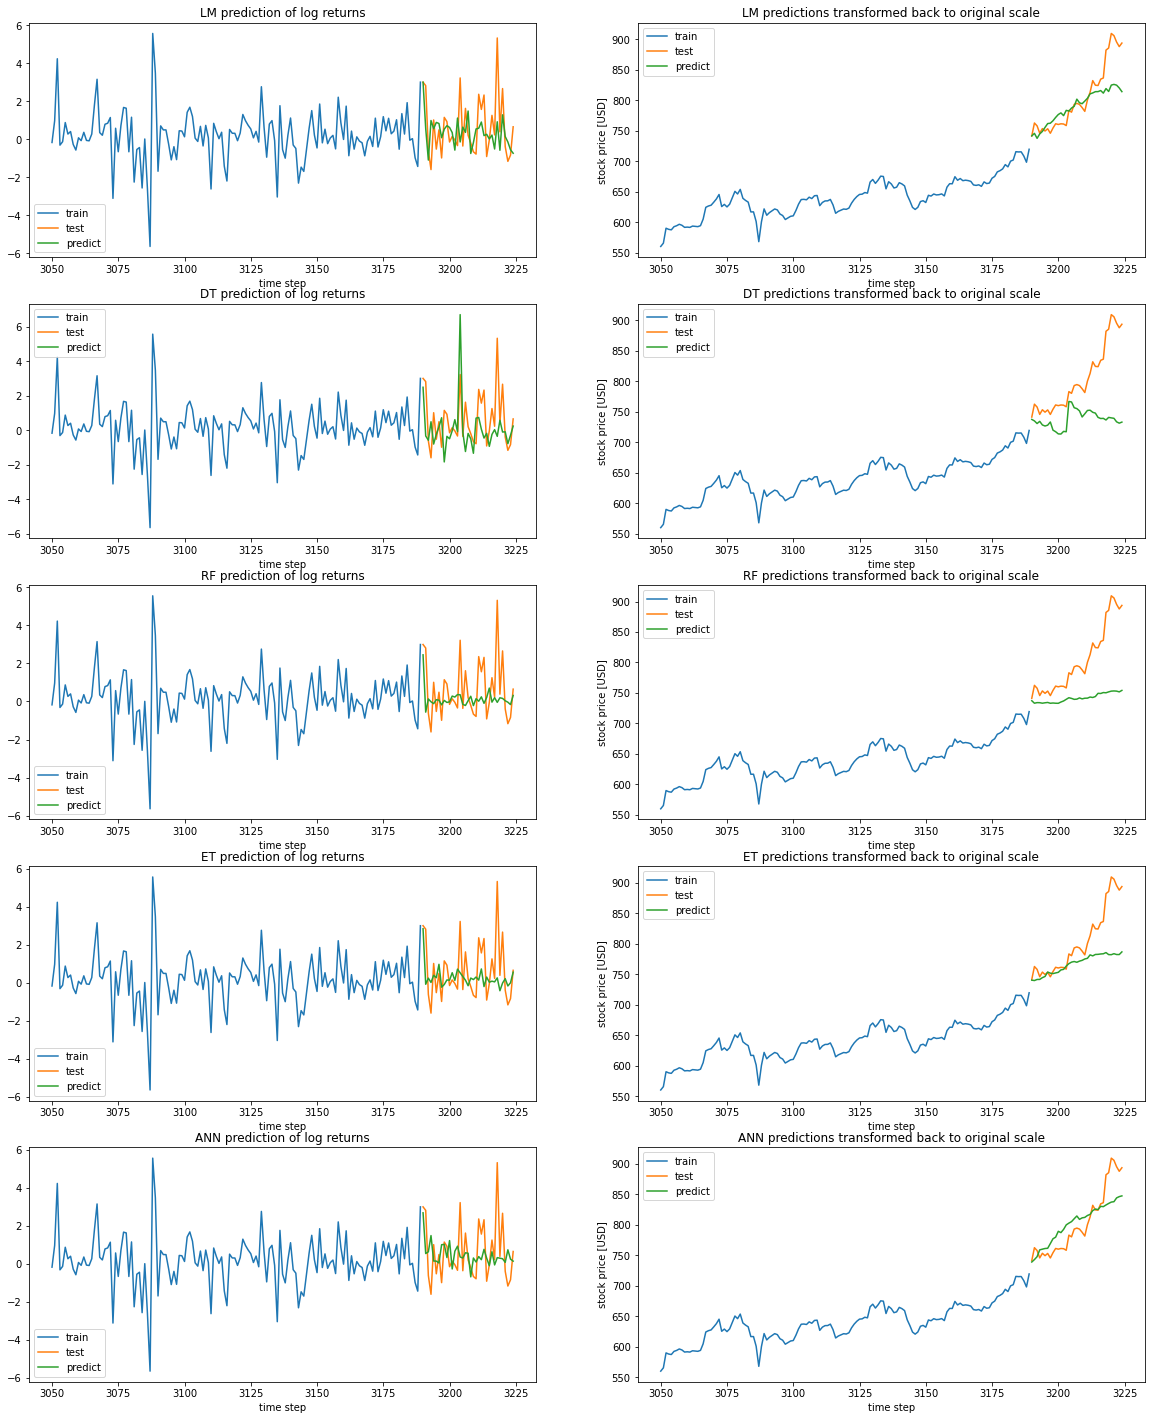

In [20]:
fig, axs =plt.subplots(len(reg),2,figsize=(20,5*len(reg)))
i = 0

for model in reg:
    
    y_predict = reg[model].predict(scaler.transform(x_test))
    y_predict = pd.DataFrame(y_predict, index=x_test.index)
    
    #we need the initial stock price to transforme the returns back into the real price
    iidx = pd.Timestamp(pd.to_datetime(y_train.index[0])+dt.timedelta(hours=-1))
    initial = tsla_price.iloc[tsla_price.index.get_loc(iidx,method="pad")]
    
    #change the returns back to the price (os=original scale)
    y_train_os = convert_from_logret(y_train,initial)
    y_test_os = convert_from_logret(y_test,data['Open'][cut_idx],axis=1)
    y_predict_os = convert_from_logret(y_predict,data['Open'][cut_idx],axis=1)
    
    
    #fig, axs =plt.subplots(1,2,figsize=(20,5))

    #n_train = len(y2_train_os['returns'])
    n_train = len(data['Open'][:cut_idx])
    n_test = len(y_test_os.iloc[0])
    #print(n_train, n_test, backward_timesteps)

    axs[i,0].plot(range(n_train+backward_timesteps,n_train),data['returns'][:cut_idx][backward_timesteps:])
    axs[i,0].plot(range(n_train,n_train+n_test),y_test.iloc[0])
    axs[i,0].plot(range(n_train,n_train+n_test),y_predict.iloc[0])

    axs[i,0].legend(['train','test','predict'])
    axs[i,0].set_title(model + ' prediction of log returns')
    axs[i,0].set_xlabel("time step")
    
    axs[i,1].plot(range(n_train+backward_timesteps,n_train),data['Open'][:cut_idx][backward_timesteps:])
    axs[i,1].plot(range(n_train,n_train+n_test),y_test_os.iloc[0])
    axs[i,1].plot(range(n_train,n_train+n_test),y_predict_os.iloc[0])
    
    axs[i,1].legend(['train','test','predict'])
    axs[i,1].set_title(model + ' predictions transformed back to original scale')
    axs[i,1].set_xlabel("time step")
    axs[i,1].set_ylabel("stock price [USD]")

    
    metrics["MSE"][model] = mean_squared_error(y_test.iloc[0], y_predict.iloc[0])
    metrics["R2"][model] = r2_score(y_test.iloc[0],y_predict.iloc[0])
    metrics["MSE_original_scale"][model] = mean_squared_error(y_test_os.iloc[0],y_predict_os.iloc[0])
    metrics["R2_original_scale"][model] = r2_score(y_test_os.iloc[0],y_predict_os.iloc[0])
    
    i=i+1

plt.show()


In [21]:
print(metrics)

          MSE        R2 MSE_original_scale R2_original_scale
LM   2.102195  0.076515        1238.834902          0.557528
DT   3.208266 -0.409377         6911.49391         -1.468566
RF   2.476327 -0.087839        5877.768817         -1.099352
ET   2.280886 -0.001983        2949.681651         -0.053533
ANN  2.404829  -0.05643         905.255126          0.676672
